In [29]:
from google.colab import drive
drive.mount('/content/drive')

import sys
FOLDERNAME='Assignment4'
dir="/content/drive/My Drive/{}".format(FOLDERNAME)
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wandb torch torchvision matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import wandb
import os
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

save_path = '/content/drive/MyDrive/Assignment4/models/best_model.pth'

Using device: cpu


In [4]:
import helpers.data_loader as data_loader
train_loader, val_loader, test_df=data_loader.get_complete_fer_setup()
test_loader=data_loader.get_test_dataloader(test_df)


In [5]:
def predict_test_set(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch.to(device)  # Only images, no labels
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            predictions.extend(predicted.cpu().numpy())

    return np.array(predictions)

In [6]:
def run_test_predictions(model, test_loader,device):
    model.to(device)
    predictions = predict_test_set(model, test_loader, device)

    results_df = test_df.copy()
    results_df['predicted_emotion'] = predictions

    return results_df, predictions

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_predictions(results_df):
    true_labels = results_df['emotion'].values
    predicted_labels = results_df['predicted_emotion'].values

    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Emotion labels for FER2013
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=emotion_labels))

    print("\nConfusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels))


In [8]:
class HybridCNN_Both(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(HybridCNN_Both, self).__init__()

        self.conv1=nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(32)

        self.pool1=nn.MaxPool2d(2, 2)
        self.pool2=nn.MaxPool2d(2, 2)
        self.pool3=nn.MaxPool2d(2, 2)

        self.dropout1=nn.Dropout2d(dropout_rate * 0.3)
        self.dropout2=nn.Dropout2d(dropout_rate * 0.3)
        self.dropout3=nn.Dropout2d(dropout_rate * 0.3)

        self.resblock1=ResNetBlock_Both(32, 64, stride=1, dropout_rate=dropout_rate * 0.3)
        self.resblock2=ResNetBlock_Both(64, 64, stride=1, dropout_rate=dropout_rate * 0.3)
        self.resblock3=ResNetBlock_Both(64, 128, stride=1, dropout_rate=dropout_rate * 0.3)
        self.resblock4=ResNetBlock_Both(128, 128, stride=1, dropout_rate=dropout_rate * 0.3)

        self.avgpool=nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_fc=nn.Dropout(dropout_rate)
        self.fc=nn.Linear(128, num_classes)

    def forward(self, x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))

        x=self.pool1(x)
        x=self.dropout1(x)

        x=self.resblock1(x)
        x=self.resblock2(x)

        x=self.pool2(x)
        x=self.dropout2(x)

        x=self.resblock3(x)
        x=self.resblock4(x)

        x=self.pool3(x)
        x=self.dropout3(x)

        x=self.avgpool(x)
        x=x.view(x.size(0), -1)

        x=self.dropout_fc(x)
        x=self.fc(x)

        return x


In [9]:
class ResNetBlock_NoReg(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_NoReg, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=True)
        self.conv2=nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=True)

        self.shortcut=nn.Sequential()

        if stride!=1 or in_channels!=out_channels:
          self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=True))

    def forward(self, x):
        identity=self.shortcut(x)
        out=F.relu(self.conv1(x))
        out=self.conv2(out)
        out+=identity
        out=F.relu(out)
        return out

class ResNetBlock_BatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock_BatchNorm, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.conv2=nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)

        self.bn1=nn.BatchNorm2d(out_channels)
        self.bn2=nn.BatchNorm2d(out_channels)

        self.shortcut=nn.Sequential()

        if stride!=1 or in_channels!=out_channels:
            self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity=self.shortcut(x)
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out+=identity
        out=F.relu(out)
        return out

class ResNetBlock_Both(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.1):
        super(ResNetBlock_Both, self).__init__()

        self.conv1=nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.conv2=nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)

        self.bn1=nn.BatchNorm2d(out_channels)
        self.bn2=nn.BatchNorm2d(out_channels)

        self.dropout1=nn.Dropout2d(dropout_rate)
        self.dropout2=nn.Dropout2d(dropout_rate)

        self.shortcut=nn.Sequential()

        if stride!=1 or in_channels!=out_channels:
            self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity=self.shortcut(x)
        out=self.dropout1(F.relu(self.bn1(self.conv1(x))))
        out=self.dropout2(self.bn2(self.conv2(out)))
        out+=identity
        out=F.relu(out)
        return out

In [14]:
#for prediction vizualizations
def detailed_evaluation(true_labels, predictions):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=emotion_labels))

    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    print("Per-class Accuracy:")
    for i, emotion in enumerate(emotion_labels):
        mask = true_labels == i
        if np.sum(mask) > 0:
            class_acc = np.mean(predictions[mask] == true_labels[mask])
            class_count = np.sum(mask)
            print(f"{emotion:10s}: {class_acc:.4f} ({class_count:4d} samples)")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    true_counts = [np.sum(true_labels == i) for i in range(7)]
    ax1.bar(emotion_labels, true_counts, color='skyblue', alpha=0.7)
    ax1.set_title('True Label Distribution')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    pred_counts = [np.sum(predictions == i) for i in range(7)]
    ax2.bar(emotion_labels, pred_counts, color='lightcoral', alpha=0.7)
    ax2.set_title('Predicted Label Distribution')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return accuracy, cm

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

save_path = '/content/drive/MyDrive/Assignment4/models/best_model.pth'

if torch.cuda.is_available():
    model = torch.load(save_path, weights_only=False)
else:
    model = torch.load(save_path, map_location=torch.device('cpu'), weights_only=False)

model.to(device)
model.eval()
print("Model loaded successfully!")

Using device: cpu
Model loaded successfully!


In [17]:
import helpers.data_loader as data_loader
train_loader, val_loader, test_df = data_loader.get_complete_fer_setup()
test_loader = data_loader.get_test_dataloader(test_df)
print("Test loader ready")

Test loader ready


In [19]:
print("Starting predictions...")
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)

        all_true_labels.extend(labels.cpu().numpy())

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1} batches...")

predictions = np.array(all_predictions)
true_labels = np.array(all_true_labels)

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
results_df = pd.DataFrame({
    'true_label': true_labels,
    'predicted_label': predictions,
    'true_emotion': [emotion_labels[i] for i in true_labels],
    'predicted_emotion': [emotion_labels[i] for i in predictions],
    'correct': true_labels == predictions
})

results_df['sample_idx'] = range(len(results_df))
print("Finished predicting")

Starting predictions...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Finished predicting


Test Accuracy: 0.6397
Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.56      0.57       467
     Disgust       0.50      0.41      0.45        56
        Fear       0.46      0.31      0.37       496
       Happy       0.83      0.86      0.85       895
         Sad       0.51      0.57      0.54       653
    Surprise       0.76      0.82      0.79       415
     Neutral       0.57      0.61      0.59       607

    accuracy                           0.64      3589
   macro avg       0.60      0.59      0.59      3589
weighted avg       0.63      0.64      0.63      3589

Confusion Matrix:
[[261  10  42  24  76   9  45]
 [ 14  23  10   1   6   0   2]
 [ 61   5 154  21 141  56  58]
 [ 14   0  14 774  20  24  49]
 [ 50   6  58  40 371   8 120]
 [  9   0  34  19   4 341   8]
 [ 38   2  22  55 110   8 372]]
Per-class Accuracy:
Angry     : 0.5589 ( 467 samples)
Disgust   : 0.4107 (  56 samples)
Fear      : 0.3105 ( 496 samples)


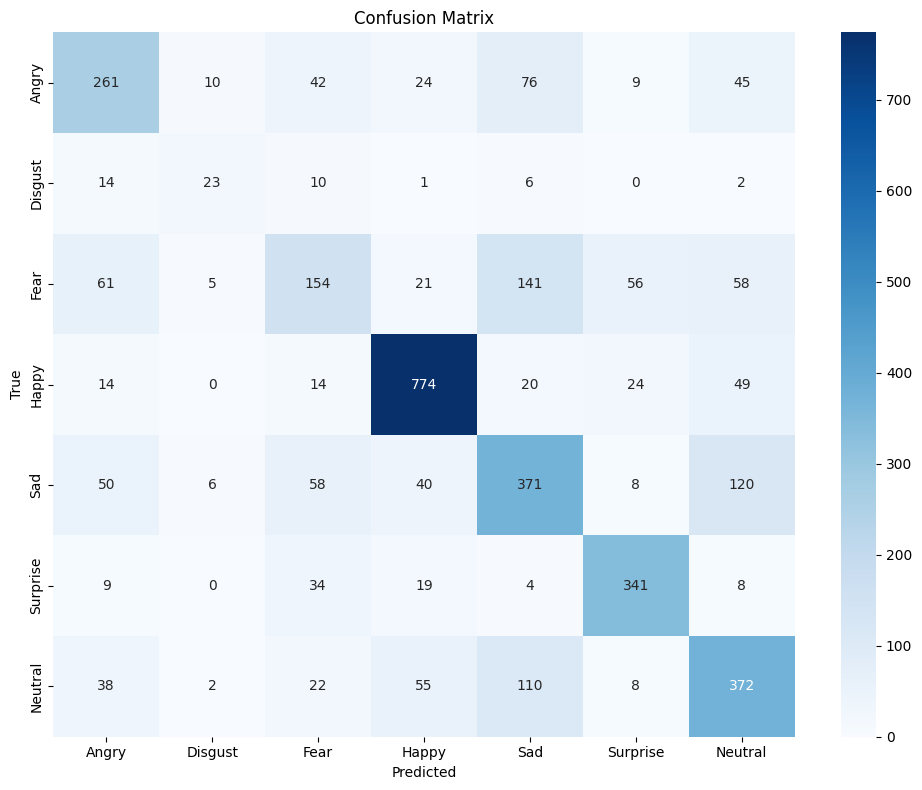

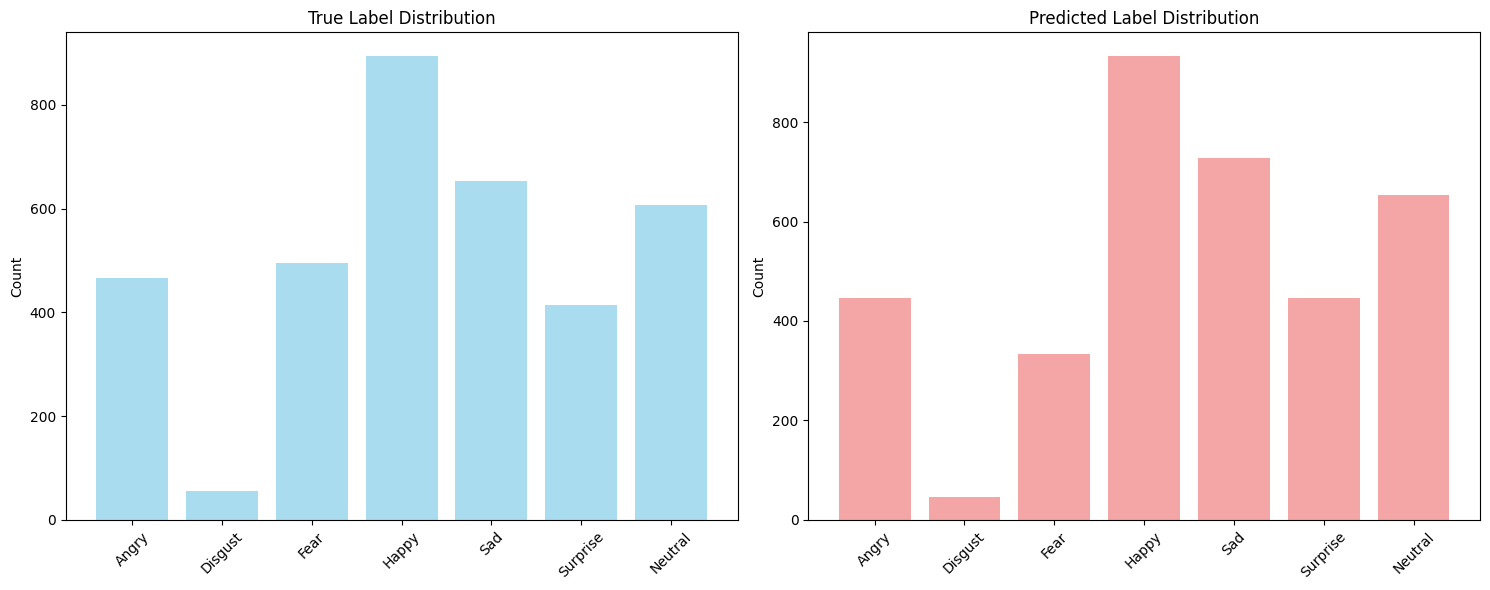

In [25]:
accuracy, cm = detailed_evaluation(true_labels, predictions)

In [26]:
print("prediction distribution:")
for i in range(7):
    count = np.sum(predictions == i)
    percentage = count/len(predictions)*100
    print(f"{emotion_labels[i]:10s}: {count:4d} ({percentage:5.1f}%)")

prediction distribution:
Angry     :  447 ( 12.5%)
Disgust   :   46 (  1.3%)
Fear      :  334 (  9.3%)
Happy     :  934 ( 26.0%)
Sad       :  728 ( 20.3%)
Surprise  :  446 ( 12.4%)
Neutral   :  654 ( 18.2%)


In [21]:
print("true label distribution:")
for i in range(7):
    count = np.sum(true_labels == i)
    percentage = count/len(true_labels)*100
    print(f"{emotion_labels[i]:10s}: {count:4d} ({percentage:5.1f}%)")

true label distribution:
Angry     :  467 ( 13.0%)
Disgust   :   56 (  1.6%)
Fear      :  496 ( 13.8%)
Happy     :  895 ( 24.9%)
Sad       :  653 ( 18.2%)
Surprise  :  415 ( 11.6%)
Neutral   :  607 ( 16.9%)


In [22]:
print("most confused emotion pairs:")
print("(true -> predicted, count)")
for i in range(7):
    for j in range(7):
        if i != j and cm[i, j] > 10:
            print(f"{emotion_labels[i]:10s} -> {emotion_labels[j]:10s}: {cm[i, j]:3d}")

most confused emotion pairs:
(true -> predicted, count)
Angry      -> Fear      :  42
Angry      -> Happy     :  24
Angry      -> Sad       :  76
Angry      -> Neutral   :  45
Disgust    -> Angry     :  14
Fear       -> Angry     :  61
Fear       -> Happy     :  21
Fear       -> Sad       : 141
Fear       -> Surprise  :  56
Fear       -> Neutral   :  58
Happy      -> Angry     :  14
Happy      -> Fear      :  14
Happy      -> Sad       :  20
Happy      -> Surprise  :  24
Happy      -> Neutral   :  49
Sad        -> Angry     :  50
Sad        -> Fear      :  58
Sad        -> Happy     :  40
Sad        -> Neutral   : 120
Surprise   -> Fear      :  34
Surprise   -> Happy     :  19
Neutral    -> Angry     :  38
Neutral    -> Fear      :  22
Neutral    -> Happy     :  55
Neutral    -> Sad       : 110


In [27]:
print("worst performing emotions:")
recalls = []
for i in range(7):
    mask = true_labels == i
    if np.sum(mask) > 0:
        recall = np.mean(predictions[mask] == true_labels[mask])
        recalls.append((recall, emotion_labels[i], np.sum(mask)))

recalls.sort()
for recall, emotion, count in recalls[:3]:
    print(f"{emotion:10s}: {recall:.3f} recall ({count} samples)")

worst performing emotions:
Fear      : 0.310 recall (496 samples)
Disgust   : 0.411 recall (56 samples)
Angry     : 0.559 recall (467 samples)


In [33]:
results_df.to_csv((f"{dir}"+"/{}").format("predictions.csv"), index=False)
print(f"final test accuracy: {accuracy:.4f}")
print("results saved to: predictions.csv")

final test accuracy: 0.6397
results saved to: predictions.csv
